# Ethereum Fraud Detection

This dataset contains rows of known fraud and valid transactions made over the Ethereum network.

### Summary of Results

80-20 train test split

train set is resampled, cross validated and used for modelling

test set is for evaluating model performance

Logistic Regression
 - Accuracy : 0.993
 - Precision: 0.968
 - Recall   : 0.981 
 - F-score  : 0.975
 - ROC AUC  : 0.989

Decision Tree
 - Accuracy : 0.982
 - Precision: 0.913
 - Recall   : 0.950
 - F-score  : 0.931
 - ROC AUC  : 0.968
 
Random Forest
 - Accuracy : 0.992
 - Precision: 0.995
 - Recall   : 0.946
 - F-score  : 0.970
 - ROC AUC  : 0.973
 
XGBoost
 - Accuracy : 0.992
 - Precision: 0.995
 - Recall   : 0.946
 - F-score  : 0.970
 - ROC AUC  : 0.973
 
SVM
 - Accuracy : 0.994
 - Precision: 0.986
 - Recall   : 0.972
 - F-score  : 0.980
 - ROC AUC  : 0.986
 
#### Precision >> Recall which is what we want for fraud detection purposes

In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve, roc_auc_score, f1_score, plot_confusion_matrix, precision_score, recall_score, classification_report
from sklearn.model_selection import cross_val_predict, StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from imblearn.combine import SMOTEENN

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("transaction_dataset.csv")

In [4]:
pd.concat([df.isna().sum(),df.nunique()],axis=1).rename(columns = {0:'Nulls',1:'Uniques'})

,Nulls,Uniques
Unnamed: 0,0,9841
Index,0,4729
Address,0,9816
FLAG,0,2
Avg min between sent tnx,0,5013
Avg min between received tnx,0,6223
Time Diff between first and last (Mins),0,7810
Sent tnx,0,641
Received Tnx,0,727
Number of Created Contracts,0,20


In [5]:
# Dropping the columns with only one unique value which means they are meaningless.
df.drop([' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx',
         ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract',
         ' ERC20 avg val sent contract', ], axis = 1, inplace = True)

# Dropping the index columns & Address which is similar to index
df.drop(['Unnamed: 0', 'Index', 'Address'], axis = 1, inplace = True)

# Dropping the columns without explaination 
df.drop(' ERC20 uniq sent addr.1', axis = 1, inplace = True) 

# Dropping duplicated rows
df.drop_duplicates(inplace = True)

In [6]:
df.rename(columns={'FLAG': 'is_fraud',
                   'Avg min between sent tnx': 'avg_time_between_sends',
                   'Avg min between received tnx': 'avg_time_between_recvs',
                   'Time Diff between first and last (Mins)': 'time_since_first_transaction',
                   'Sent tnx': 'sent_transactions',
                   'Received Tnx': 'recv_transactions',
                   'Number of Created Contracts': 'num_created_contracts',
                   'Unique Received From Addresses': 'total_addr_recv',
                   'Unique Sent To Addresses': 'total_addr_sent',
                   'min value received': 'min_val_recv',
                   'max value received ': 'max_val_recv',
                   'avg val received': 'avg_val_recv',
                   'min val sent': 'min_val_sent',
                   'max val sent': 'max_val_sent',
                   'avg val sent': 'avg_val_sent',
                   'min value sent to contract': 'min_val_sent_contracts',
                   'max val sent to contract': 'max_val_sent_contracts',
                   'avg value sent to contract': 'avg_val_sent_contracts',
                   'total transactions (including tnx to create contract': 'total_transactions',
                   'total Ether sent': 'total_ether_sent',
                   'total ether received': 'total_ether_recv',
                   'total ether sent contracts': 'total_ether_sent_contracts',
                   'total ether balance': 'total_ether_balance',
                   ' Total ERC20 tnxs': 'erc_total_transactions',
                   ' ERC20 total Ether received': 'erc_ether_recv',
                   ' ERC20 total ether sent': 'erc_ether_sent',
                   ' ERC20 total Ether sent contract': 'erc_ether_sent_contracts',
                   ' ERC20 uniq sent addr': 'erc_total_addr_sent',
                   ' ERC20 uniq rec addr': 'erc_total_addr_recv',
                   ' ERC20 uniq rec contract addr': 'erc_total_addr_sent_contracts',
                   ' ERC20 min val rec': 'erc_min_val_recv',
                   ' ERC20 max val rec': 'erc_max_val_recv',
                   ' ERC20 avg val rec': 'erc_avg_val_recv',
                   ' ERC20 min val sent': 'erc_min_val_sent',
                   ' ERC20 max val sent': 'erc_max_val_sent',
                   ' ERC20 avg val sent': 'erc_avg_val_sent',
                   ' ERC20 uniq sent token name': 'erc_unique_tokens_sent',
                   ' ERC20 uniq rec token name': 'erc_unique_tokens_recv',
                   ' ERC20 most sent token type': 'erc_most_sent_token',
                   ' ERC20_most_rec_token_type': 'erc_most_recv_token'}, inplace=True)

## EDA

### Insights from EDA:
1. The longer the 'avg_time_between_recvs', the more likely the transaction is fraud.
2. Non-fraud transactions condensed around 0 for 'time_since_first_transaction'.
3. From the plot, fraud transactions only occur when the number of 'sent_transactions' is small.
4. There are more fraud transactions when the number of 'recv_transactions' is small.
5. From the plot, fraud transactions usually occur when the number of 'total_addr_sent' is small.
6. the outlier in max val sent does not affect if the transcation is fraud or not, from the graph, it shows that all the fraud points are clustered to the left
7. however, for min and avg val sent, the fraud data is spread all over
8. for min,max, avg sent contracts, all fraud data are coresponding to a zero value
9. total_ether_sent and recv: for both graphs, they show that their fraud points are corresponding to 0
10. total_ether_bal:fraud points are corresponding to 0
11. erc_total_trans's outliers have no effects on fraud
12. erc_ether sent outlier has an influcence on fraud
13. erc_min/max/avg has the same distribution and all outliers have major effect on fraud.
14. we decided to drop min/max/avg/total_val_sent_contracts because 99 percent data are 0 and they all have very low variance, therefore, they are not going to help future analyze the model

0    7639
1    1656
Name: is_fraud, dtype: int64


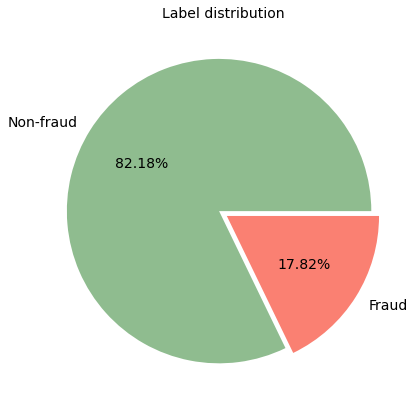

In [7]:
# Inspect target distribution
print(df['is_fraud'].value_counts())

pie, ax = plt.subplots(figsize=[10,7])
labels = ['Non-fraud', 'Fraud']
colors = ['darkseagreen', 'salmon']
plt.pie(x = df['is_fraud'].value_counts()
        , autopct='%.2f%%', labels=labels, colors = colors, textprops={'fontsize': 14}, explode=[0.03]*2)
plt.title('Label distribution',fontsize=14)
plt.show()

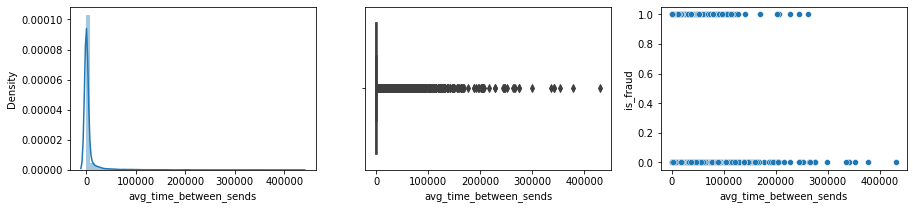

In [8]:
# 1. plot the distribution of 'avg_time_between_sends'
plt.figure(figsize=(15, 3))
ax1 = plt.subplot(1, 3, 1)
ax1 = sns.distplot(df['avg_time_between_sends'], kde = True)

ax2 = plt.subplot(1, 3, 2)
ax2 = sns.boxplot(x = df['avg_time_between_sends'])

ax2 = plt.subplot(1, 3, 3)
ax3 = sns.scatterplot(data = df, x = 'avg_time_between_sends', y = 'is_fraud')

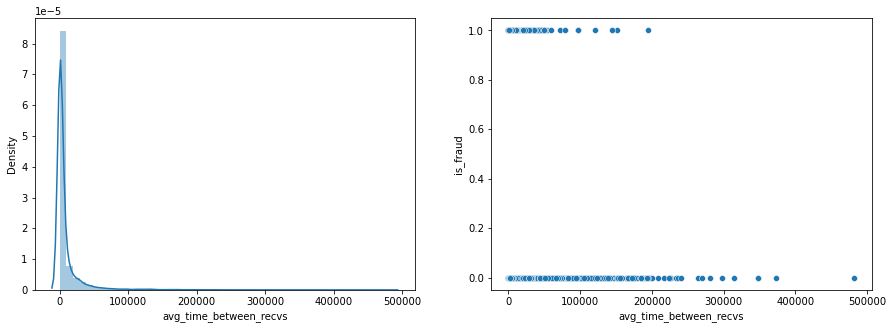

In [9]:
# 2. plot the distribution of 'avg_time_between_recvs'
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
ax1 = sns.distplot(df['avg_time_between_recvs'], kde = True)

ax2 = plt.subplot(1, 2, 2)
ax2 = sns.scatterplot(data = df, x = 'avg_time_between_recvs', y = 'is_fraud')

(0.0, 500.0)

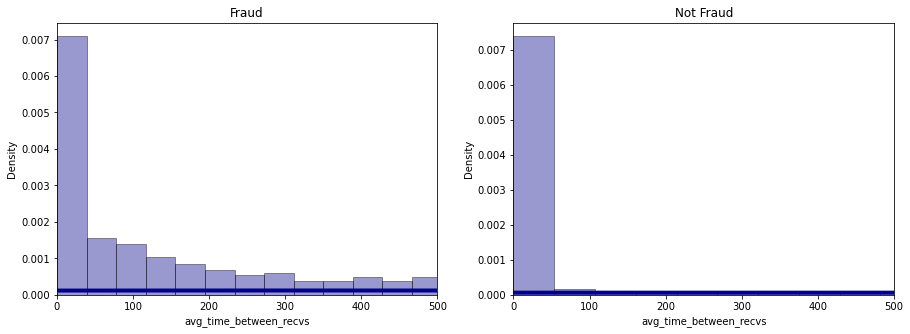

In [10]:
df_temp_1 = df[df['is_fraud']== 1]
df_temp_2 = df[df['is_fraud']== 0]

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
ax1 = sns.distplot(df_temp_1['avg_time_between_recvs'], hist=True, kde=True, 
             bins=int(5000), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title("Fraud")
plt.xlim(0, 500)

ax2 = plt.subplot(1, 2, 2)
ax2 = sns.distplot(df_temp_2['avg_time_between_recvs'], hist=True, kde=True, 
             bins=int(9000), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title("Not Fraud")
plt.xlim(0, 500)

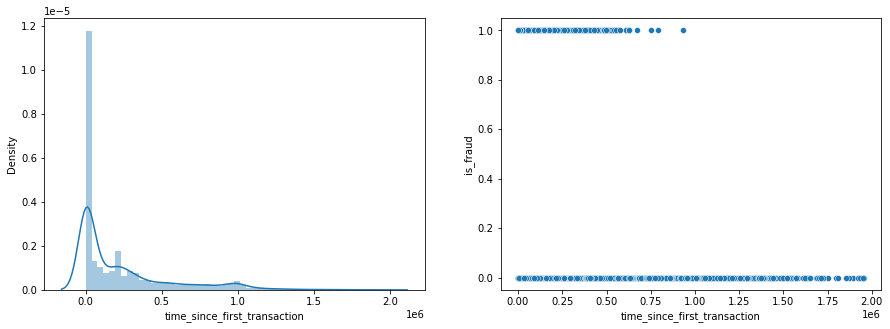

In [11]:
# 3. plot the distribution of 'time_since_first_transaction'
x_name = 'time_since_first_transaction'
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
ax1 = sns.distplot(df[x_name], kde = True)

ax2 = plt.subplot(1, 2, 2)
ax2 = sns.scatterplot(data = df, x = x_name, y = 'is_fraud')

(0.0, 10000.0)

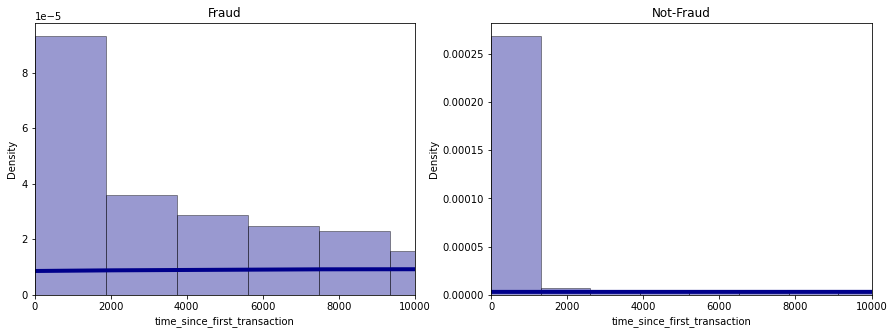

In [12]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
ax1 = sns.distplot(df_temp_1['time_since_first_transaction'], hist=True, kde=True, 
             bins=int(500), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title("Fraud")
plt.xlim(0, 10000)

ax1 = plt.subplot(1, 2, 2)
sns.distplot(df_temp_2['time_since_first_transaction'], hist=True, kde=True, 
             bins=int(1500), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}).set_title("Not-Fraud")
plt.xlim(0, 10000)

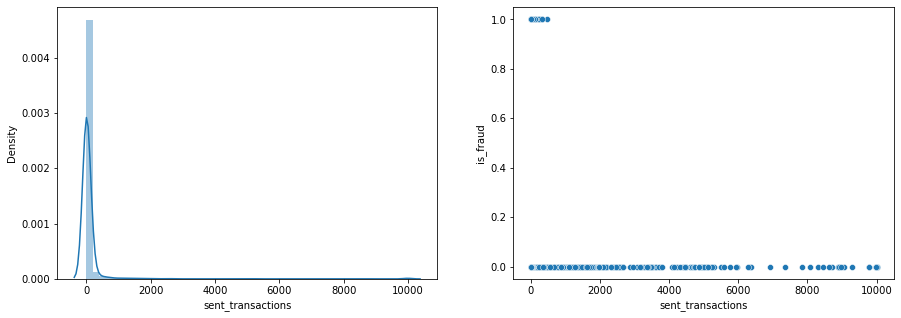

In [13]:
# 4. plot the distribution of 'sent_transactions'
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
ax1 = sns.distplot(df['sent_transactions'])

ax2 = plt.subplot(1, 2, 2)
ax2 = sns.scatterplot(data = df, x = 'sent_transactions', y = 'is_fraud')

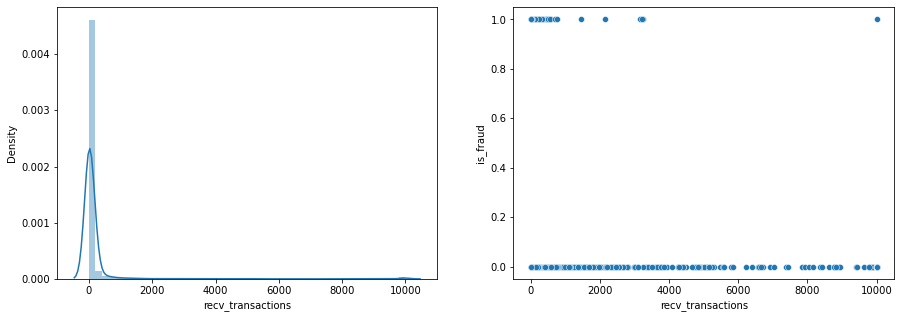

In [14]:
# 5. plot the distribution of 'recv_transactions'
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
ax1 = sns.distplot(df['recv_transactions'])

ax2 = plt.subplot(1, 2, 2)
ax2 = sns.scatterplot(data = df, x = 'recv_transactions', y = 'is_fraud')

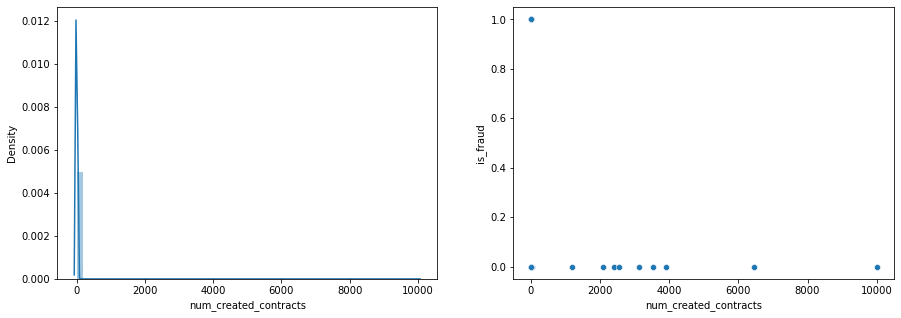

In [15]:
# 6. plot the distribution of 'num_created_contracts'
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
ax1 = sns.distplot(df['num_created_contracts'])

ax2 = plt.subplot(1, 2, 2)
ax2 = sns.scatterplot(data = df, x = 'num_created_contracts', y = 'is_fraud')

<AxesSubplot:xlabel='total_addr_recv', ylabel='is_fraud'>

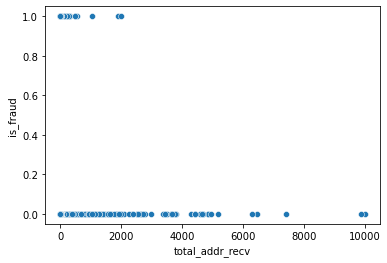

In [16]:
# 7. plot the distribution of 'total_addr_recv'
sns.scatterplot(data = df, x = 'total_addr_recv', y = 'is_fraud')

<AxesSubplot:xlabel='total_addr_sent', ylabel='is_fraud'>

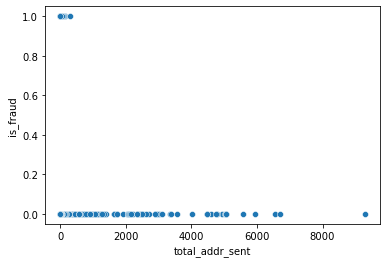

In [17]:
# 8. plot the distribution of 'total_addr_sent'
sns.scatterplot(data = df, x = 'total_addr_sent', y = 'is_fraud')

<AxesSubplot:xlabel='min_val_recv', ylabel='is_fraud'>

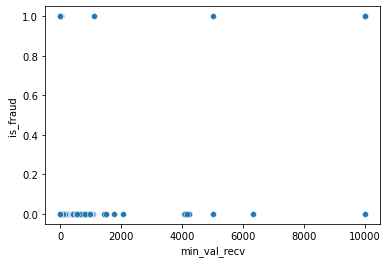

In [18]:
# 9. plot the distribution of 'min_val_recv'
sns.scatterplot(data = df, x = 'min_val_recv', y = 'is_fraud')

<AxesSubplot:xlabel='max_val_recv', ylabel='is_fraud'>

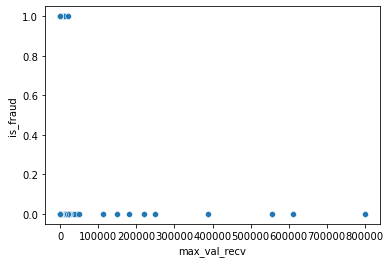

In [19]:
# 10. plot the distribution of 'max_val_recv'
sns.scatterplot(data = df, x = 'max_val_recv', y = 'is_fraud')

<AxesSubplot:xlabel='avg_val_recv', ylabel='is_fraud'>

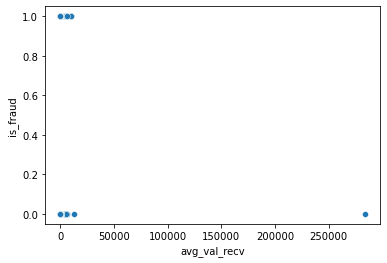

In [20]:
# 11. plot the distribution of 'avg_val_recv'
sns.scatterplot(data = df, x = 'avg_val_recv', y = 'is_fraud')

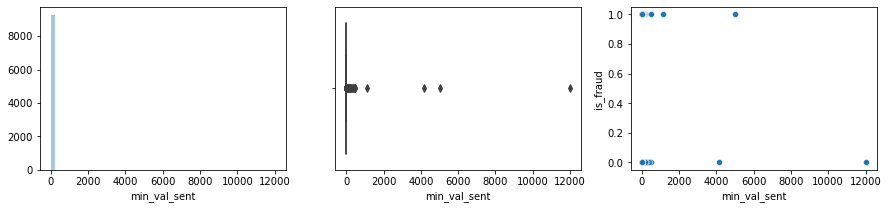

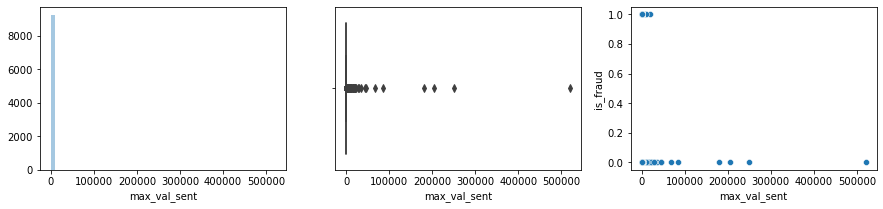

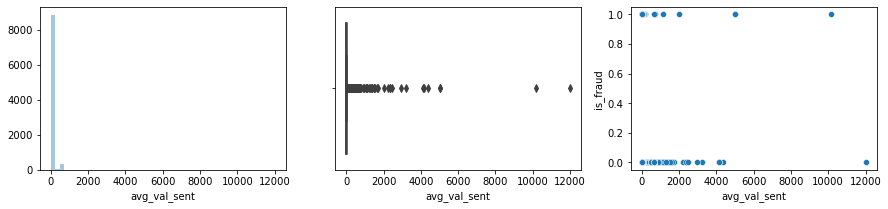

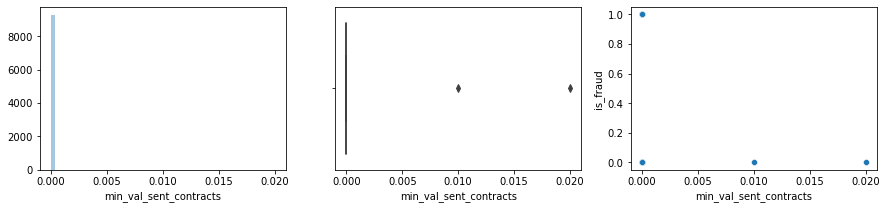

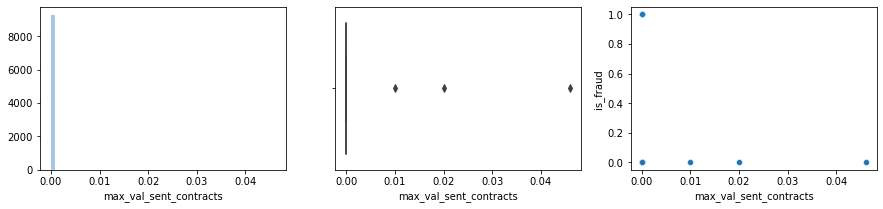

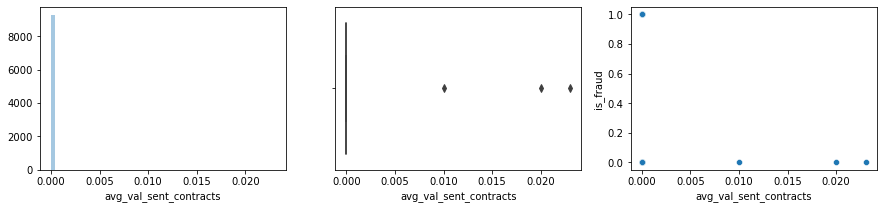

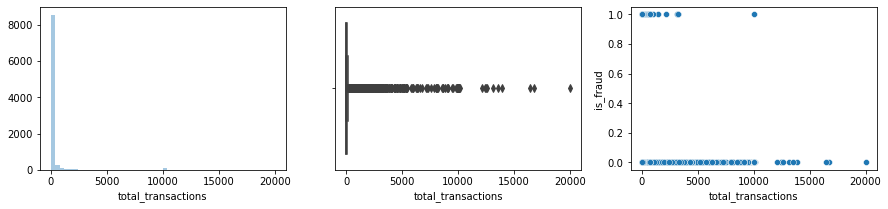

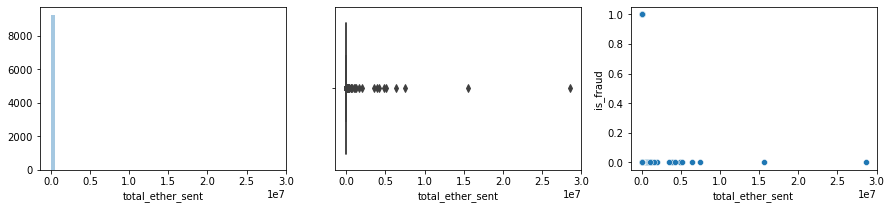

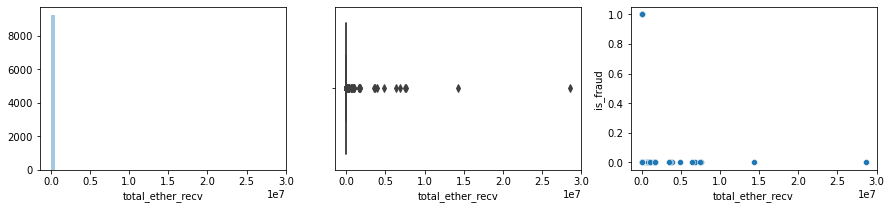

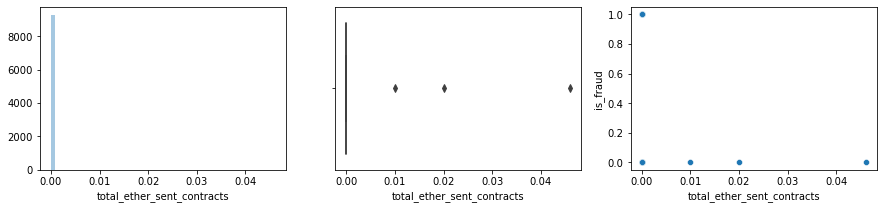

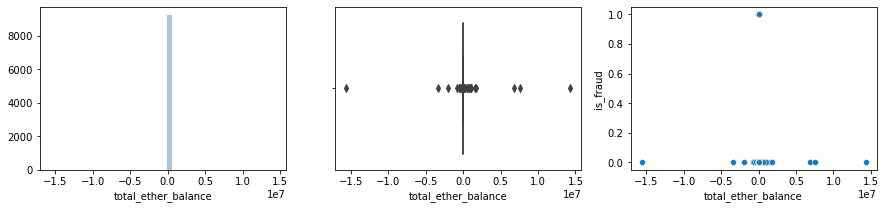

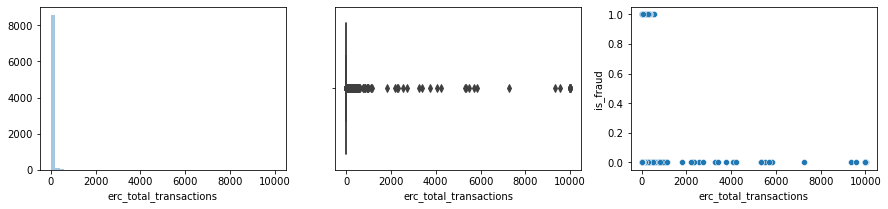

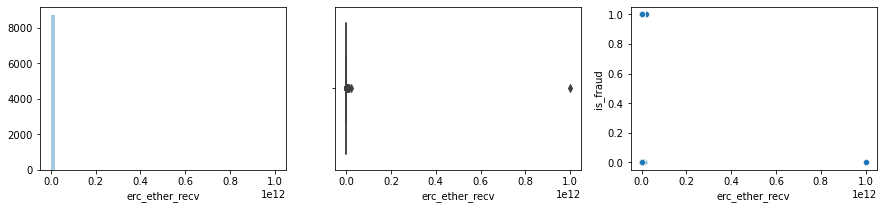

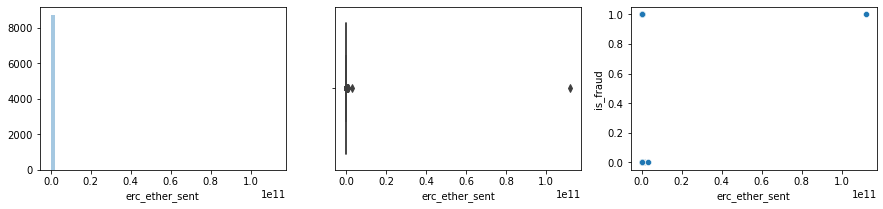

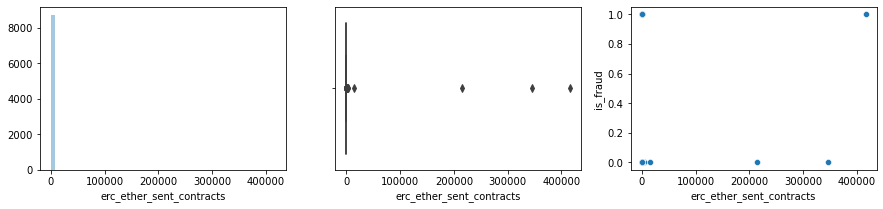

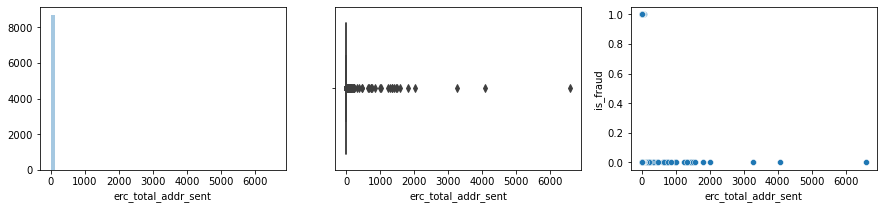

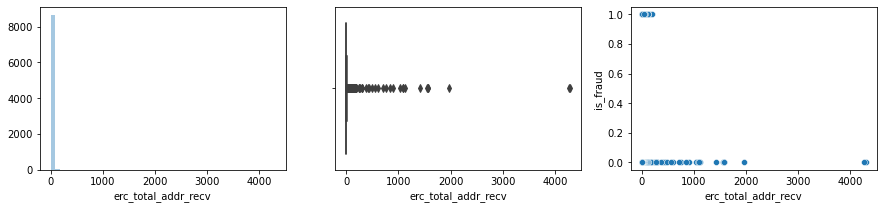

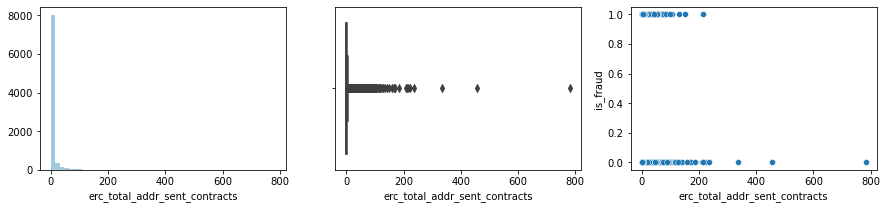

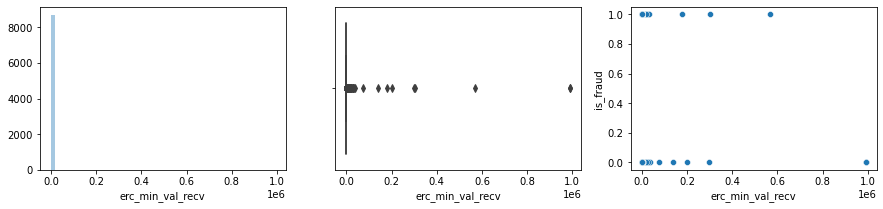

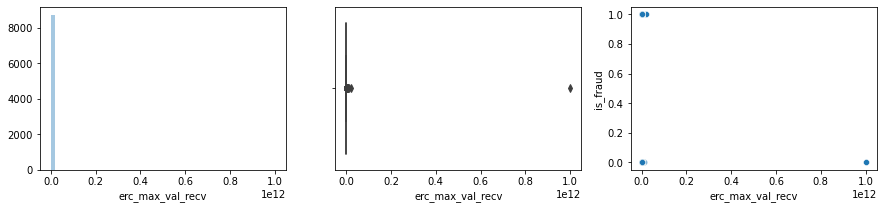

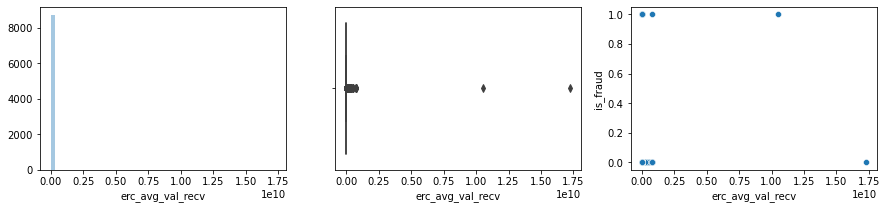

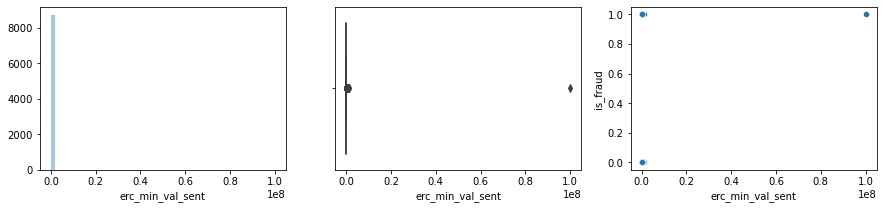

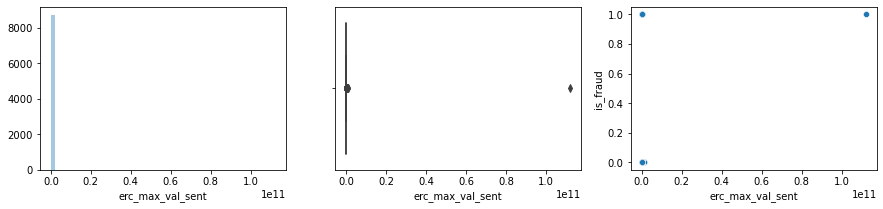

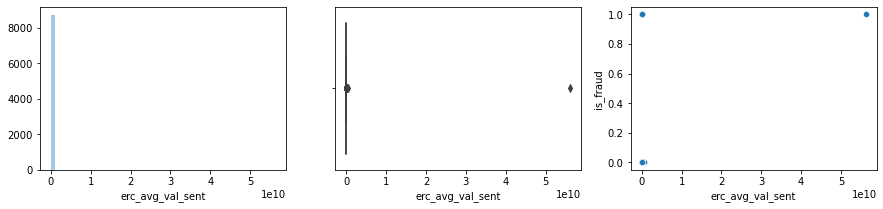

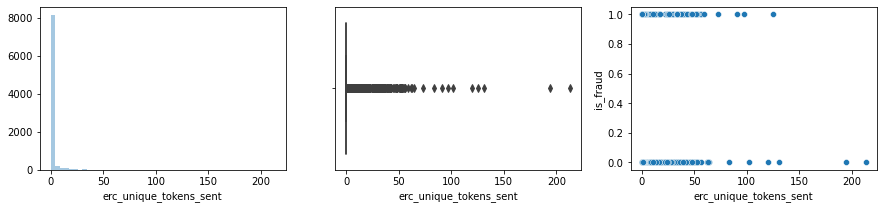

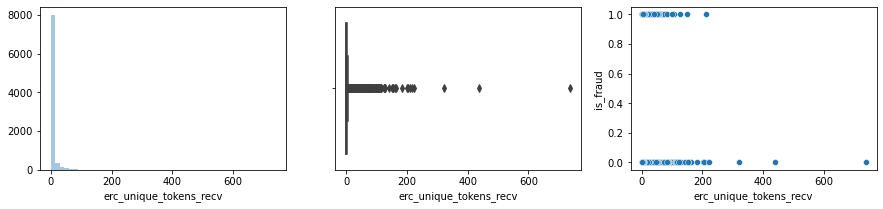

In [21]:
for col in list(df.columns)[12:-2]: #Expect taget column and object columns

    plt.figure(figsize=(15, 3))
    # plot the distribution
    ax1 = plt.subplot(1, 3, 1)
    ax1 = sns.distplot(df[col], kde=False)

    # display the dataset based on the five-number summary
    ax2 = plt.subplot(1, 3, 2)
    ax2 = sns.boxplot(x = df[col])

    ax3 = plt.subplot(1, 3, 3)
    ax3 = sns.scatterplot(data = df, x = col, y = 'is_fraud')

    plt.show()

In [22]:
# Some features present a small distribution(Variance)
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 10:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column min_val_sent_contracts has the following distribution: 
0.00    9293
0.02       1
0.01       1
Name: min_val_sent_contracts, dtype: int64
The column max_val_sent_contracts has the following distribution: 
0.000000    9292
0.020000       1
0.010000       1
0.046029       1
Name: max_val_sent_contracts, dtype: int64
The column avg_val_sent_contracts has the following distribution: 
0.000000    9292
0.020000       1
0.010000       1
0.023014       1
Name: avg_val_sent_contracts, dtype: int64
The column total_ether_sent_contracts has the following distribution: 
0.000000    9292
0.020000       1
0.010000       1
0.046029       1
Name: total_ether_sent_contracts, dtype: int64


In [23]:
df.drop(['min_val_sent_contracts', 'max_val_sent_contracts', 'avg_val_sent_contracts', 'total_ether_sent_contracts']
        , axis = 1, inplace = True)

Text(0.5, 1.0, 'Correlation coefficient of the variables')

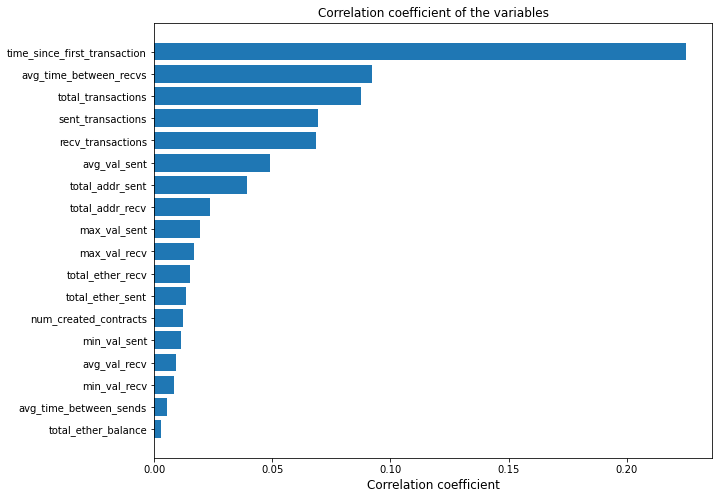

In [24]:
# Correlation coefficience for all columns

x_cols = []
for col in df.columns:
    if col not in ['is_fraud'] and df[col].dtype!='object':
            x_cols.append(col)
            
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.is_fraud)[0, 1])
    
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df= corr_df.dropna() # drop Correlation coefficient = 0
corr_df.corr_values=corr_df.corr_values.apply(lambda x: abs(x))
corr_df = corr_df.sort_values('corr_values')

fig,ax = plt.subplots(figsize = (10,8))
ax.barh(corr_df.col_labels, corr_df.corr_values)
ax.set_xlabel('Correlation coefficient',fontsize=12)
ax.set_title('Correlation coefficient of the variables',fontsize=12)

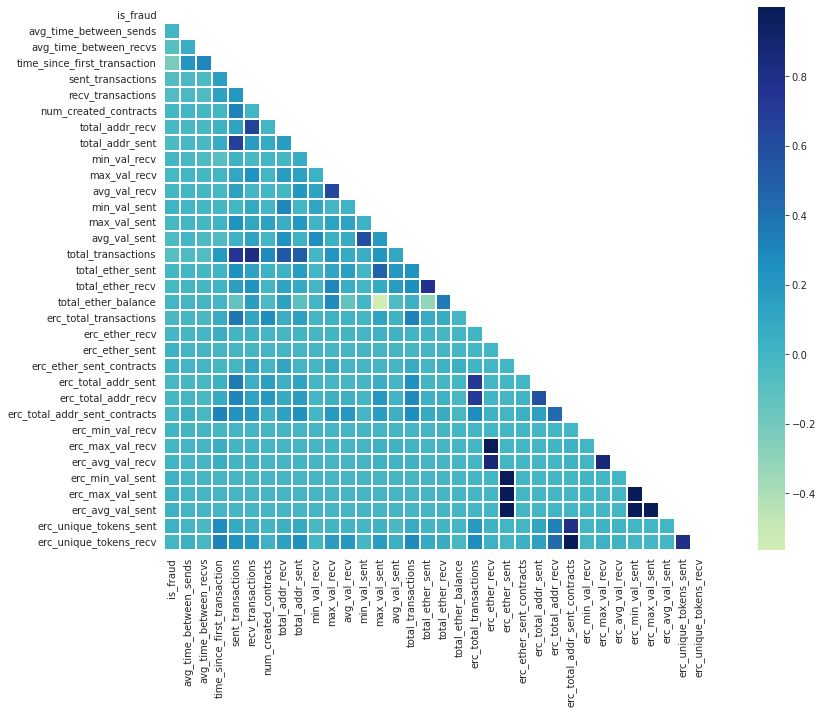

In [25]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap="YlGnBu", center=0, linewidths=0.1, square=True)

## TSNE

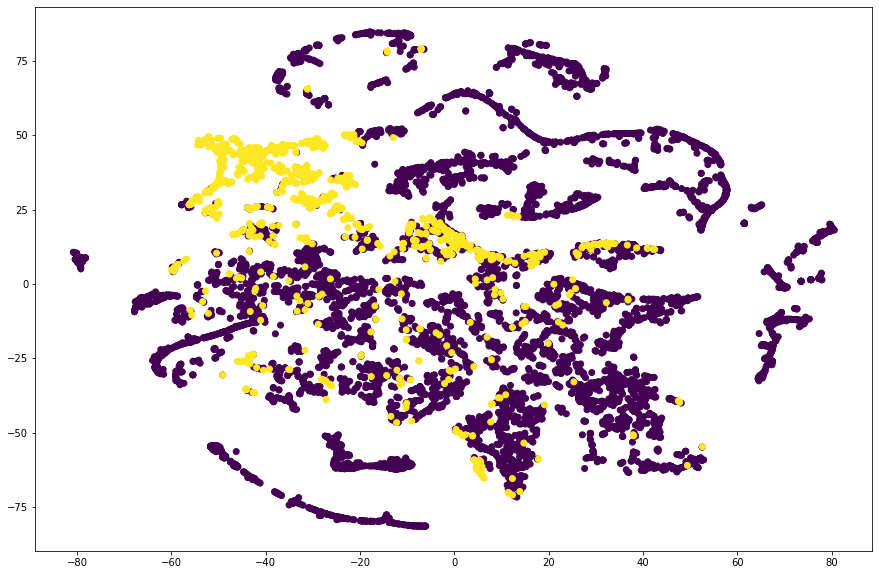

In [26]:
df_tsne = df
df_tsne = df_tsne.drop(['is_fraud', 'erc_most_sent_token', 'erc_most_recv_token'], axis = 1)

scaler = StandardScaler()
std_tsne = scaler.fit_transform(df_tsne)
df_std_tsne = pd.DataFrame(std_tsne, columns = df_tsne.columns)
df_std_tsne['is_fraud'] = df.is_fraud.values
df_std_tsne = df_std_tsne.dropna()

model=TSNE(learning_rate=100, random_state = 1)
Tsne_transformed=model.fit_transform(df_std_tsne.drop(['is_fraud'], axis = 1).values)
xs = Tsne_transformed[:,0]
ys = Tsne_transformed[:,1]
plt.figure(figsize = (15,10))
plt.scatter(xs,ys,c=df_std_tsne.is_fraud.values)
plt.show()

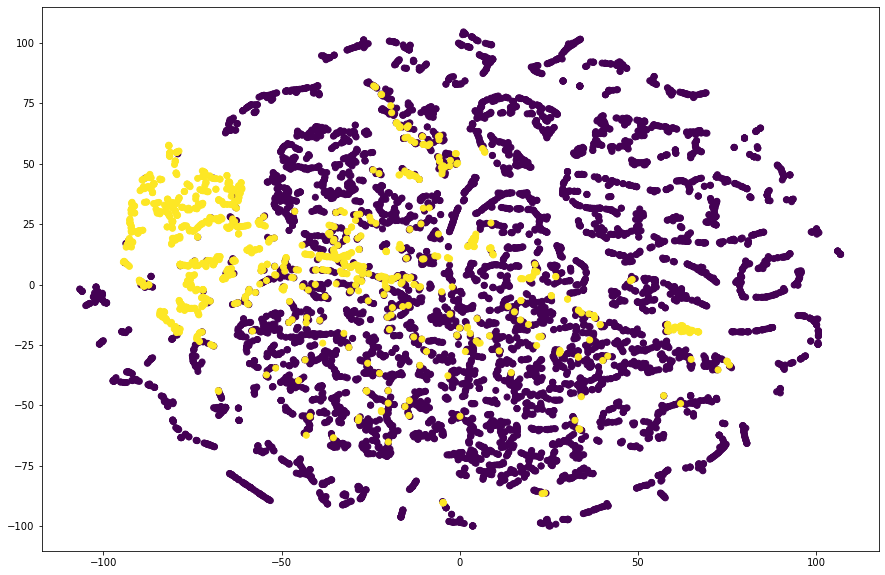

In [27]:
from sklearn.manifold import TSNE
model=TSNE(perplexity=10, learning_rate=100, random_state = 1)
Tsne_transformed=model.fit_transform(df_std_tsne.drop(['is_fraud'], axis = 1).values)
xs = Tsne_transformed[:,0]
ys = Tsne_transformed[:,1]
plt.figure(figsize = (15,10))
plt.scatter(xs,ys,c=df_std_tsne.is_fraud.values)
plt.show()

## Feature Engineering

In [28]:
# Dropping the columns with high correlation to other independent variables. (corr >= 0.7)
# Drop erc_total_transactions as it is the sum of total_ether_sent and total_ether_received
to_drop = ['total_transactions','erc_total_addr_sent_contracts','erc_min_val_sent','erc_total_transactions',
           'erc_ether_sent','erc_ether_recv']

df_temp = df.drop(to_drop, axis=1)

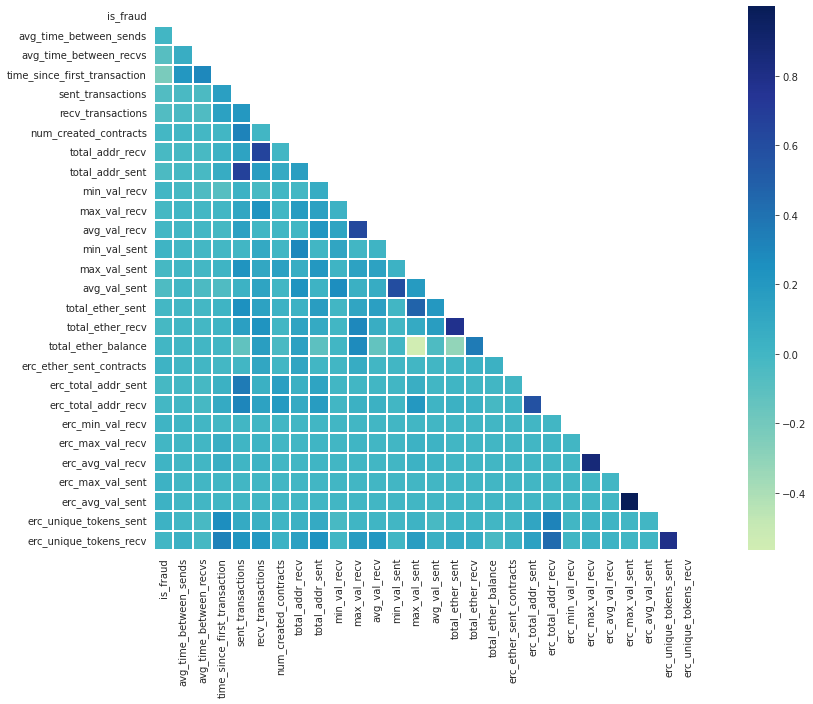

In [29]:
# Recheck the Correlation matrix
corr = df_temp.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap="YlGnBu", center=0, linewidths=0.1, square=True)

In [30]:
df1 = df.copy()

# Drop rows with missing erc data
df1 = df1[df1['erc_ether_recv'].notna()]

In [31]:
# feature cross

# ratios comparing ERC Token transactions and Ether transactions
df1['total_ether_token_recv_ratio'] = df1['total_ether_recv']/df1['erc_ether_recv']
df1['total_ether_token_sent_ratio'] = df1['total_ether_sent']/df1['erc_ether_sent']
df1['avg_ether_token_recv_ratio'] = df1['avg_val_recv']/df1['erc_avg_val_recv']
df1['avg_ether_token_sent_ratio'] = df1['avg_val_sent']/df1['erc_avg_val_sent']

df1['total_ether_token_recv_ratio'] = df1['total_ether_token_recv_ratio'].replace([np.inf, -np.inf], -1)
df1['total_ether_token_sent_ratio'] = df1['total_ether_token_sent_ratio'].replace([np.inf, -np.inf], -1)
df1['avg_ether_token_recv_ratio'] = df1['avg_ether_token_recv_ratio'].replace([np.inf, -np.inf], -1)
df1['avg_ether_token_sent_ratio'] = df1['avg_ether_token_sent_ratio'].replace([np.inf, -np.inf], -1)

df1['total_ether_token_recv_ratio'] = df1['total_ether_token_recv_ratio'].replace(-1, max(df1['total_ether_token_recv_ratio'])).fillna(0)
df1['total_ether_token_sent_ratio'] = df1['total_ether_token_sent_ratio'].replace(-1, max(df1['total_ether_token_sent_ratio'])).fillna(0)
df1['avg_ether_token_recv_ratio'] = df1['avg_ether_token_recv_ratio'].replace(-1, max(df1['avg_ether_token_recv_ratio'])).fillna(0)
df1['avg_ether_token_sent_ratio'] = df1['avg_ether_token_sent_ratio'].replace(-1, max(df1['avg_ether_token_sent_ratio'])).fillna(0)

# Ratios comparing maximum transaction values and average transaction values
df1['erc_max_avg_val_recv'] = df1['erc_max_val_recv']/df1['erc_avg_val_recv']
df1['erc_max_avg_val_recv'] = df1['erc_max_avg_val_recv'].fillna(1)

df1['erc_max_avg_val_sent'] = df1['erc_max_val_sent']/df1['erc_avg_val_sent']
df1['erc_max_avg_val_sent'] = df1['erc_max_avg_val_sent'].fillna(1)

df1['erc_max_avg_val_recv'] = df1['erc_max_avg_val_recv'].replace([np.inf, -np.inf], -1)
df1['erc_max_avg_val_recv'] = df1['erc_max_avg_val_recv'].replace(-1, max(df1['erc_max_avg_val_recv']))

df1['erc_max_avg_val_sent'] = df1['erc_max_avg_val_sent'].replace([np.inf, -np.inf], -1)
df1['erc_max_avg_val_sent'] = df1['erc_max_avg_val_sent'].replace(-1, max(df1['erc_max_avg_val_sent']))

In [32]:
# Feature to show if the minimum and maximum value sent is equal 
## 'erc_max_val_sent' & 'erc_min_val_sent' have high correlation.
df1['erc_equal_max_min_val_sent'] = df1.apply(lambda x: 1 if (x['erc_max_val_sent'] == x['erc_min_val_sent']) else 0,axis=1)

In [33]:
# Change string column into numeric 
most_sent_fraud_ratio = df1.groupby(['erc_most_sent_token'])['is_fraud']\
                           .mean()\
                           .reset_index()\
                           .rename(columns={'is_fraud':'erc_most_sent_token_fraud'})
            
most_recv_fraud_ratio = df1.groupby(['erc_most_recv_token'])['is_fraud']\
                           .mean()\
                           .reset_index()\
                           .rename(columns={'is_fraud':'erc_most_recv_token_fraud'})

df1 = df1.merge(most_sent_fraud_ratio, on='erc_most_sent_token', how="left")
df1 = df1.merge(most_recv_fraud_ratio, on='erc_most_recv_token', how="left")

df1['erc_most_sent_token_fraud'] = df1['erc_most_sent_token_fraud'].fillna(0)
df1['erc_most_recv_token_fraud'] = df1['erc_most_recv_token_fraud'].fillna(0)
df1.drop(['erc_most_recv_token','erc_most_sent_token'], axis =1, inplace = True)

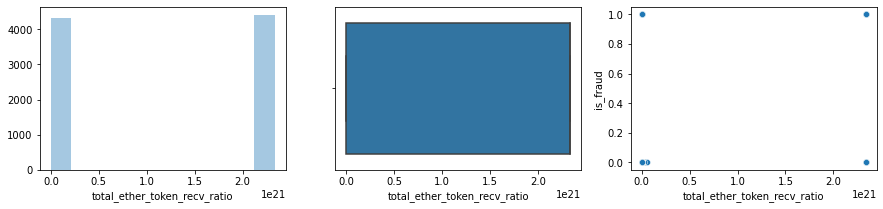

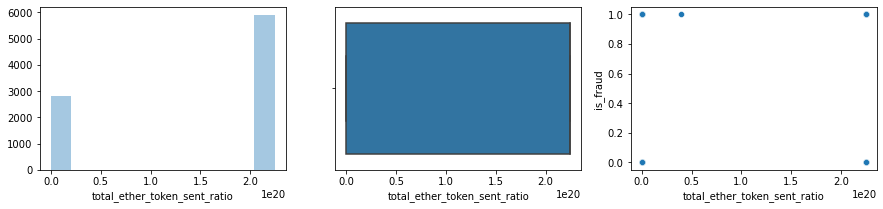

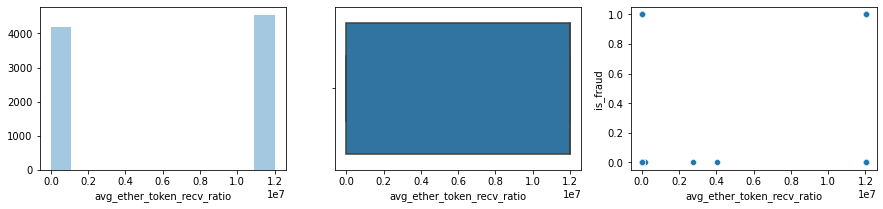

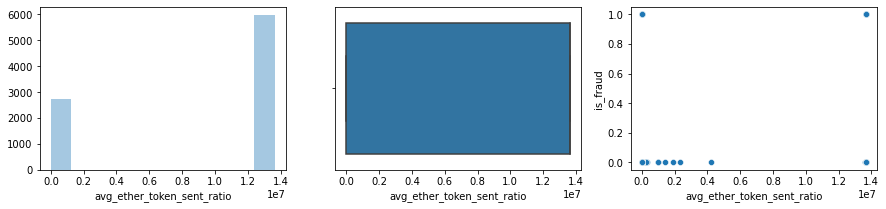

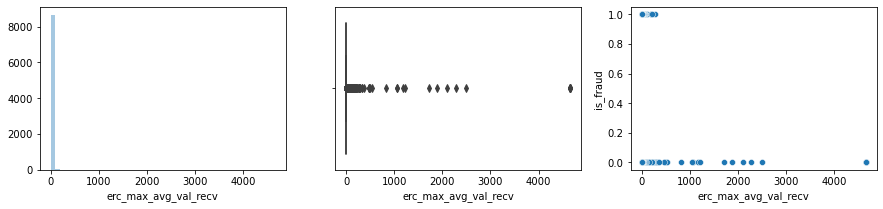

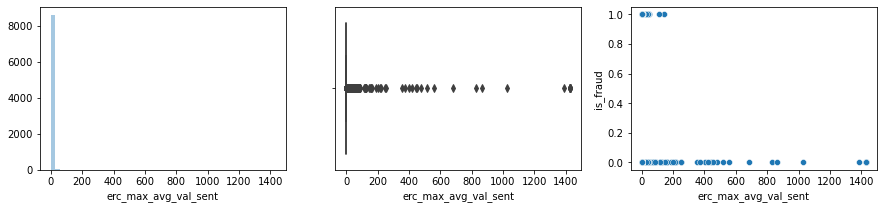

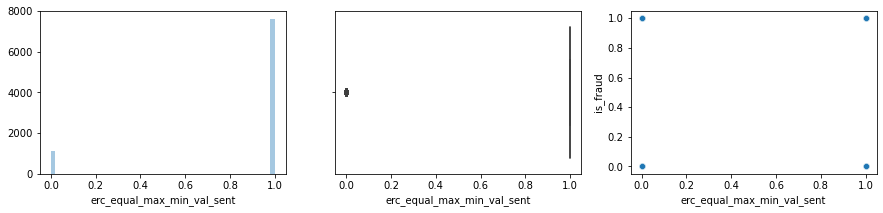

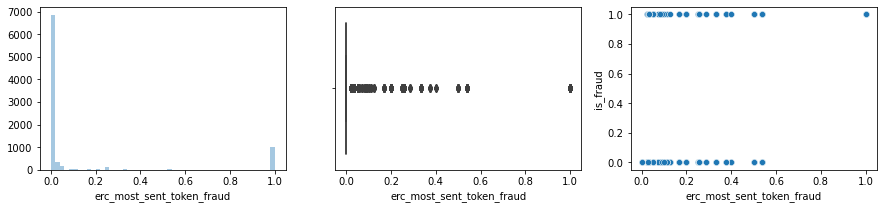

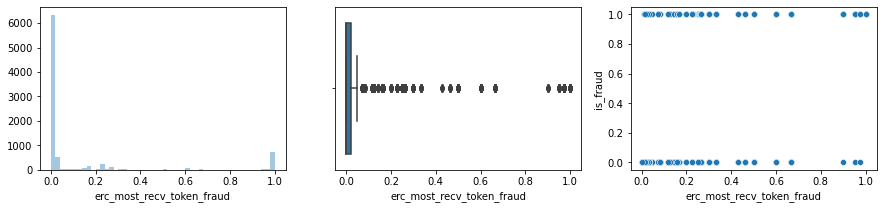

In [34]:
new_cols = ['is_fraud','total_ether_token_recv_ratio','total_ether_token_sent_ratio',
            'avg_ether_token_recv_ratio','avg_ether_token_sent_ratio',
            'erc_max_avg_val_recv','erc_max_avg_val_sent','erc_equal_max_min_val_sent',
            'erc_most_sent_token_fraud','erc_most_recv_token_fraud']

for col in list(new_cols)[1:]: #Expect target column and object columns

    plt.figure(figsize=(15, 3))
    # plot the distribution
    ax1 = plt.subplot(1, 3, 1)
    ax1 = sns.distplot(df1[col], kde=False)

    # display the dataset based on the five-number summary
    ax2 = plt.subplot(1, 3, 2)
    ax2 = sns.boxplot(x = df1[col])

    ax3 = plt.subplot(1, 3, 3)
    ax3 = sns.scatterplot(data = df1, x = col, y = 'is_fraud')

    plt.show()

In [35]:
df1 = df1.drop(to_drop, axis=1)

Text(0.5, 1.0, 'Correlation coefficient of the variables')

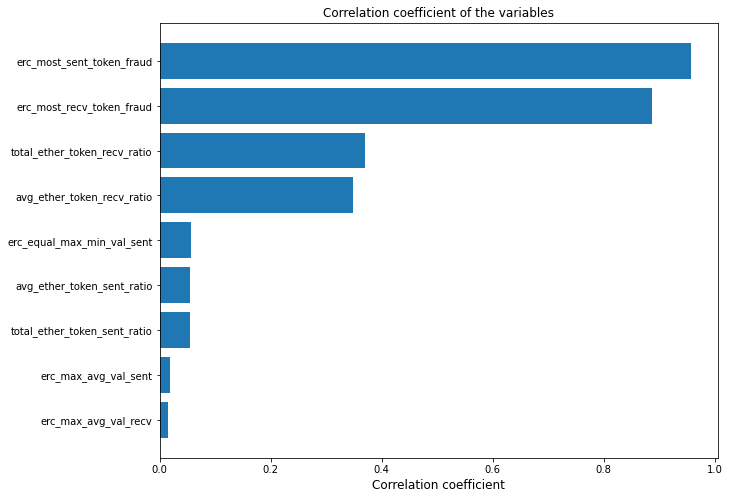

In [36]:
# Recheck feature correlations of engineered features
x_cols = []
for col in new_cols:
    if col not in ['is_fraud'] and df1[col].dtype!='object':
            x_cols.append(col)
            
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df1[col].values, df1.is_fraud)[0, 1])
    
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df.corr_values = corr_df.corr_values.apply(lambda x: abs(x))
corr_df = corr_df.sort_values('corr_values')

fig,ax = plt.subplots(figsize = (10,8))
ax.barh(corr_df.col_labels, corr_df.corr_values)
ax.set_xlabel('Correlation coefficient',fontsize=12)
ax.set_title('Correlation coefficient of the variables',fontsize=12)

In [37]:
pd.concat([df1.isna().sum(),df1.nunique()],axis=1).rename(columns = {0:'Nulls',1:'Uniques'})

,Nulls,Uniques
is_fraud,0,2
avg_time_between_sends,0,4831
avg_time_between_recvs,0,5825
time_since_first_transaction,0,7287
sent_transactions,0,641
recv_transactions,0,726
num_created_contracts,0,20
total_addr_recv,0,252
total_addr_sent,0,258
min_val_recv,0,4431


In [38]:
df1.shape

(8746, 37)

## Resampling

80-20 train test split

train set is resampled, cross validated and used for modelling

test set is for evaluating model performance

In [39]:
X = df1.drop(['is_fraud'], axis=1)
y = df1['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=80)

In [40]:
smt = SMOTEENN()

In [41]:
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [42]:
pd.concat([y_train.value_counts().rename('original'), y_smt.value_counts().rename('smoteenn')], axis=1)

,original,smoteenn
0,6111,4853
1,885,5727


## Modelling

In [43]:
# Feature Standardizaton
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(X_smt)
X_train_scaled = scalar.transform(X_smt)
X_test_scaled = scalar.transform(X_test)


In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### 1. Logistic Regression

In [45]:
RANDOM_STATE = 42

In [46]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = RANDOM_STATE)
lr.fit(X_train_scaled, y_smt)
y_pred_lr = lr.predict(X_test_scaled)

In [47]:
print('Classification Report for Logistic Regression Model: \n', classification_report(y_test, y_pred_lr))

Classification Report for Logistic Regression Model: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1528
           1       0.97      0.97      0.97       222

    accuracy                           0.99      1750
   macro avg       0.98      0.98      0.98      1750
weighted avg       0.99      0.99      0.99      1750



In [48]:
print('Metrics for Logistic Regression Model: ')
print(f'Accuracy : {accuracy_score(y_test, y_pred_lr).round(5)}')
print(f'Precision: {precision_score(y_test, y_pred_lr).round(5)}')
print(f'Recall   : {recall_score(y_test, y_pred_lr).round(5)}')
print(f'F1-score  : {f1_score(y_test, y_pred_lr).round(5)}')
print(f'ROC AUC  : {roc_auc_score(y_test, y_pred_lr).round(5)}')

Metrics for Logistic Regression Model: 
Accuracy : 0.99257
Precision: 0.96861
Recall   : 0.97297
F1-score  : 0.97079
ROC AUC  : 0.9842


In [49]:
# Utility function to compute AUC_ROC score and plot the curve.
def auc_roc(y_pred_probs, y_test):
  auc = roc_auc_score(y_test, y_pred_probs)
  print('AUC Score: %.2f\n' % auc)

  fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
  plt.plot(fpr, tpr, color = 'orange', label = 'ROC')
  plt.plot([0,1], [0,1], color = 'darkblue', linestyle = '--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()

In [50]:
pred_prob = lr.predict_proba(X_test_scaled)
probs = pred_prob[:, 1]

AUC Score: 1.00



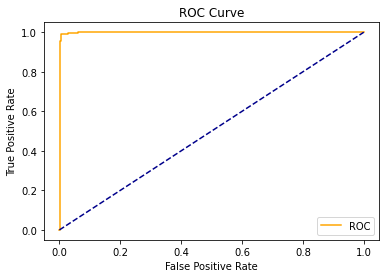

In [51]:
auc_roc(probs, y_test)

Logistic: f1=0.000 auc=0.563


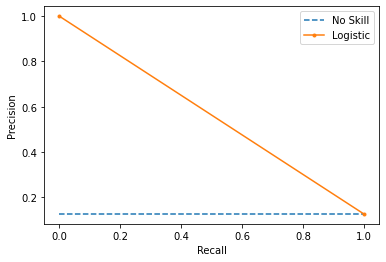

In [52]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(random_state = RANDOM_STATE)
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision) 
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### 2. Decision Tree

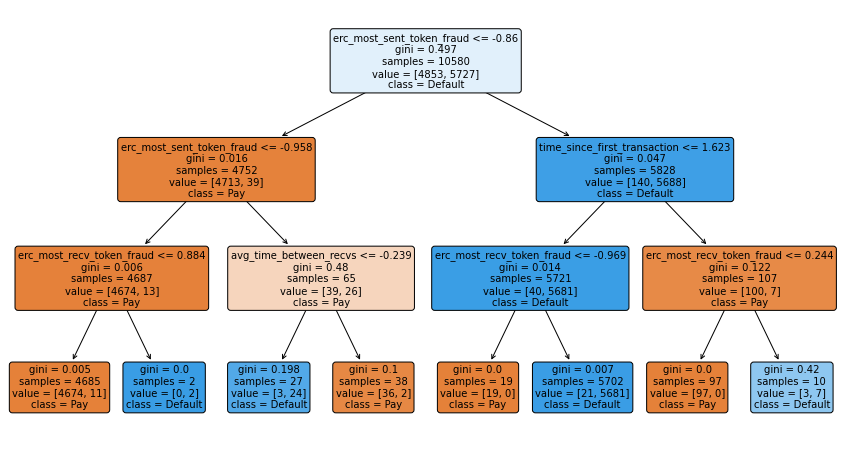

In [53]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3)
# Train Decision Tree Classifer
dt = dt.fit(X_train_scaled, y_smt)
plt.figure(figsize=(15,8))
tree.plot_tree(dt, fontsize=10,feature_names = X.columns,
               class_names=['Pay','Default'],
               filled = True,rounded=True)
plt.show()

In [54]:
y_pred_dt = dt.predict(X_test_scaled)

In [55]:
print("\nClassification Report for Decision Tree:\n", classification_report(y_test, y_pred_dt))


Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1528
           1       0.96      0.97      0.96       222

    accuracy                           0.99      1750
   macro avg       0.98      0.98      0.98      1750
weighted avg       0.99      0.99      0.99      1750



In [56]:
print('Metrics for Decision Tree Model: ')
print(f'Accuracy : {accuracy_score(y_test, y_pred_dt).round(5)}')
print(f'Precision: {precision_score(y_test, y_pred_dt).round(5)}')
print(f'Recall   : {recall_score(y_test, y_pred_dt).round(5)}')
print(f'F1-score  : {f1_score(y_test, y_pred_dt).round(5)}')
print(f'ROC AUC  : {roc_auc_score(y_test, y_pred_dt).round(5)}')

Metrics for Decision Tree Model: 
Accuracy : 0.99086
Precision: 0.95982
Recall   : 0.96847
F1-score  : 0.96413
ROC AUC  : 0.98129


AUC Score: 0.98



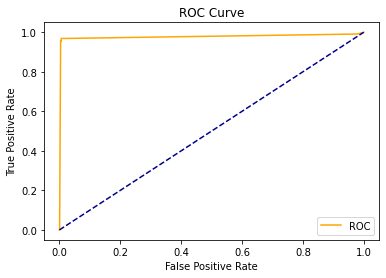

In [57]:
pred_prob = dt.predict_proba(X_test_scaled)
probs = pred_prob[:, 1]
auc_roc(probs, y_test)

Logistic: f1=0.977 auc=0.986


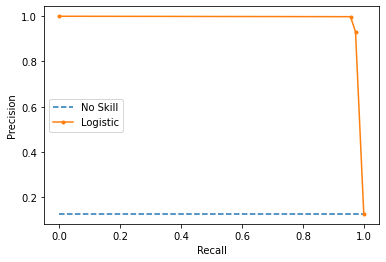

In [58]:
# precision-recall curve and f1
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = DecisionTreeClassifier(max_depth=3)
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision) 
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### 3. Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rf = RandomForestClassifier(random_state = RANDOM_STATE)


In [61]:
rf.fit(X_train_scaled, y_smt)
y_pred_rf = rf.predict(X_test_scaled)

In [62]:
print('Classification Report for Random Forest Model: \n', classification_report(y_test, y_pred_rf))

Classification Report for Random Forest Model: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1528
           1       1.00      0.94      0.97       222

    accuracy                           0.99      1750
   macro avg       0.99      0.97      0.98      1750
weighted avg       0.99      0.99      0.99      1750



In [63]:
print('Metrics for Random Forest Model: ')
print(f'Accuracy : {accuracy_score(y_test, y_pred_rf).round(5)}')
print(f'Precision: {precision_score(y_test, y_pred_rf).round(5)}')
print(f'Recall   : {recall_score(y_test, y_pred_rf).round(5)}')
print(f'F1-score  : {f1_score(y_test, y_pred_rf).round(5)}')
print(f'ROC AUC  : {roc_auc_score(y_test, y_pred_rf).round(5)}')

Metrics for Random Forest Model: 
Accuracy : 0.992
Precision: 0.99524
Recall   : 0.94144
F1-score  : 0.96759
ROC AUC  : 0.97039


AUC Score: 1.00



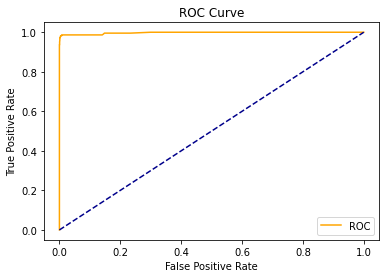

In [64]:
pred_prob = rf.predict_proba(X_test_scaled)
probs = pred_prob[:, 1]
auc_roc(probs, y_test)

Logistic: f1=0.984 auc=0.997


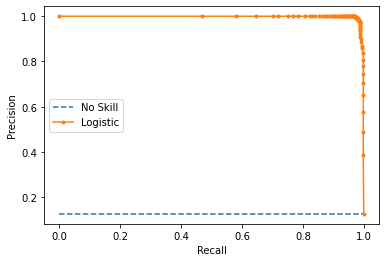

In [65]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = RandomForestClassifier(random_state = RANDOM_STATE)
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision) 
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### 4. XGBoost

In [66]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state = RANDOM_STATE)

In [67]:
xgb.fit(X_train_scaled, y_smt)
y_pred_xgb = rf.predict(X_test_scaled)

[02:11:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [68]:
print("\nClassification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))


Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1528
           1       1.00      0.94      0.97       222

    accuracy                           0.99      1750
   macro avg       0.99      0.97      0.98      1750
weighted avg       0.99      0.99      0.99      1750



In [69]:
print('Metrics for XGBoost Model: ')
print(f'Accuracy : {accuracy_score(y_test, y_pred_xgb).round(5)}')
print(f'Precision: {precision_score(y_test, y_pred_xgb).round(5)}')
print(f'Recall   : {recall_score(y_test, y_pred_xgb).round(5)}')
print(f'F1-score  : {f1_score(y_test, y_pred_xgb).round(5)}')
print(f'ROC AUC  : {roc_auc_score(y_test, y_pred_xgb).round(5)}')

Metrics for XGBoost Model: 
Accuracy : 0.992
Precision: 0.99524
Recall   : 0.94144
F1-score  : 0.96759
ROC AUC  : 0.97039


AUC Score: 1.00



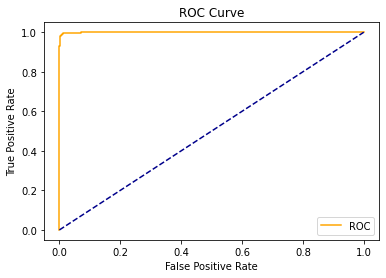

In [70]:
pred_prob = xgb.predict_proba(X_test_scaled)
probs = pred_prob[:, 1]
auc_roc(probs, y_test)

### 5. SVM

In [71]:
from sklearn.svm import SVC

In [72]:
svc = SVC(random_state = RANDOM_STATE)

In [73]:
svc.fit(X_train_scaled, y_smt)
y_pred_svc = svc.predict(X_test_scaled)

In [74]:
print('Classification Report for SVM Model: \n', classification_report(y_test, y_pred_svc))

Classification Report for SVM Model: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1528
           1       0.98      0.97      0.98       222

    accuracy                           0.99      1750
   macro avg       0.99      0.98      0.99      1750
weighted avg       0.99      0.99      0.99      1750



In [75]:
print('Metrics for SVM Model: ')
print(f'Accuracy : {accuracy_score(y_test, y_pred_svc).round(5)}')
print(f'Precision: {precision_score(y_test, y_pred_svc).round(5)}')
print(f'Recall   : {recall_score(y_test, y_pred_svc).round(5)}')
print(f'F1-score  : {f1_score(y_test, y_pred_svc).round(5)}')
print(f'ROC AUC  : {roc_auc_score(y_test, y_pred_svc).round(5)}')

Metrics for SVM Model: 
Accuracy : 0.99371
Precision: 0.97738
Recall   : 0.97297
F1-score  : 0.97517
ROC AUC  : 0.98485


## Final Model

Since we care about precision the most in our business context, our selection for the model will be either Random Forest or XGBoost(precision = 1).

In addition, Random Forest provides interpretability and less training time, therefore we pick Random Forest as our final model.

We then use cross validation to do hyperparameter tuning to further fine tune our model.

In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
rf = RandomForestClassifier(oob_score = True, random_state = RANDOM_STATE, n_jobs = -1)
param_grid = {'n_estimators': [200, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [2, 4, 6, 8],
              'criterion': ['gini', 'entropy']}
CV_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10)
CV_rf.fit(X_train_scaled, y_smt)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [78]:
print(CV_rf.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


In [79]:
print(CV_rf.best_score_)

0.9992438563327031


In [80]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, max_features='auto', n_estimators= 500, 
                             max_depth=8, criterion='gini')

In [81]:
rf.fit(X_train_scaled, y_smt)
y_pred_rf = rf.predict(X_test_scaled)

In [82]:
print('Classification Report for Random Forest Model: \n', classification_report(y_test, y_pred_rf))

Classification Report for Random Forest Model: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1528
           1       1.00      0.94      0.97       222

    accuracy                           0.99      1750
   macro avg       0.99      0.97      0.98      1750
weighted avg       0.99      0.99      0.99      1750



AUC Score: 1.00



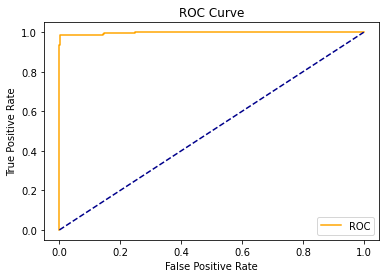

In [83]:
pred_prob = rf.predict_proba(X_test_scaled)
probs = pred_prob[:, 1]
auc_roc(probs, y_test)

Logistic: f1=0.984 auc=0.997


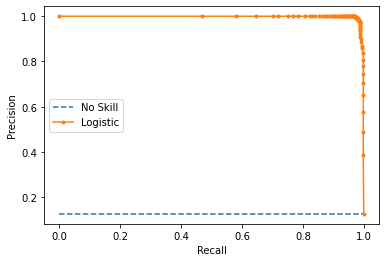

In [84]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = RandomForestClassifier(random_state = RANDOM_STATE)
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision) 
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

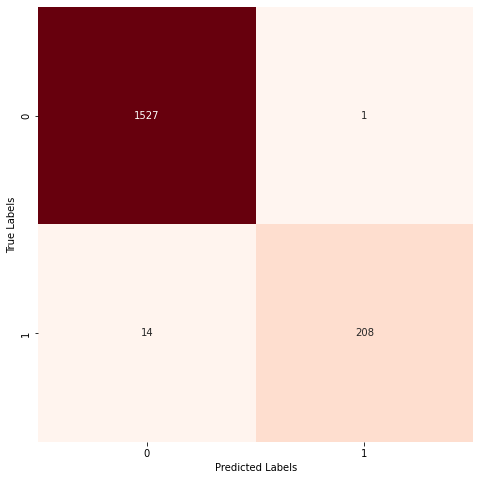

In [85]:
matrix_confusion = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Reds', fmt='d', cbar=False)
fig=plt.gcf()
fig.set_size_inches(8,8)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [86]:
print(f'Accuracy : {accuracy_score(y_test, y_pred_rf).round(5)}')
print(f'Precision: {precision_score(y_test, y_pred_rf).round(5)}')
print(f'Recall   : {recall_score(y_test, y_pred_rf).round(5)}')
print(f'F1-score  : {f1_score(y_test, y_pred_rf).round(5)}')
print(f'ROC AUC  : {roc_auc_score(y_test, y_pred_rf).round(5)}')

Accuracy : 0.99143
Precision: 0.99522
Recall   : 0.93694
F1-score  : 0.9652
ROC AUC  : 0.96814


We finally achieve a precision score of 99.5% with model Random Forest.

In [87]:
# Feature Importance
importance = rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_], axis=0)

data={'feature_names':X_train.columns,'feature_importance':importance,'standard_deviation':std}
fi_df = pd.DataFrame(data)

fi_df = fi_df.sort_values(by=['feature_importance'], ascending=False)

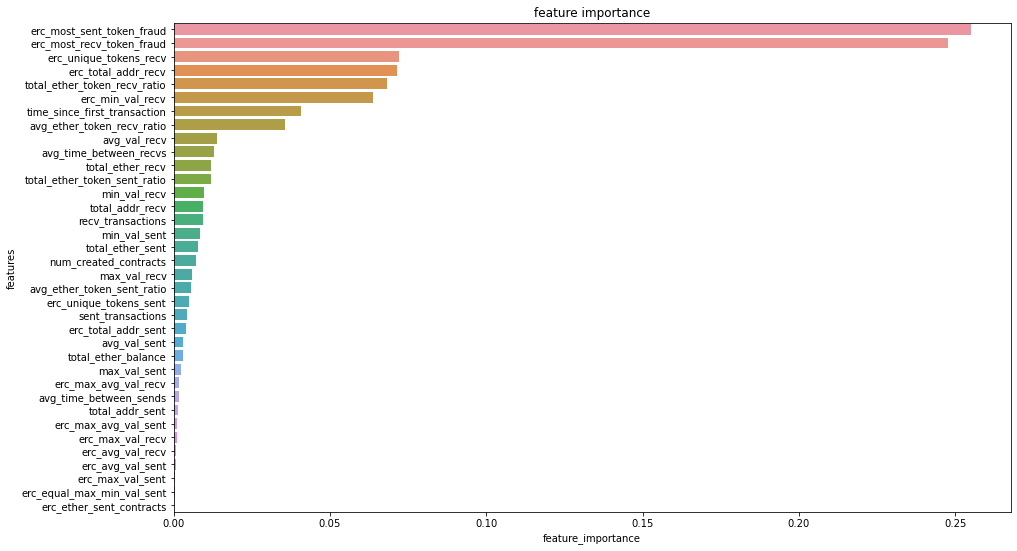

In [88]:
plt.figure(figsize=(15,9))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
plt.title('feature importance')
plt.ylabel('features')
plt.show()